# Generative model for MOT images
## Team: Loic Anderegg, Daniel Ang, Andrei Gheorghe

The high level objective of this project is to get the temperature of a gas of molecules or atoms trapped in a magneto-optical trap (MOT). For this, the first goal is to fit images of the MOT taken on a CCD camera to 2D Gaussians, which is our basic guess for its shape. On top of shape we also model multiple sources of uncertainty, from statistical uncertainty in our 2D Gaussian guess to uncertainties arising from shot noise, readout noise or scattered light noise. 

To actually get the temperature of the gas we physically have to release the molecules/atoms from the trap and let them expand. From the expansion rate we can then infer the temeprature. Thus, the second goal is to analyze multiple such images taken at different times after the release from the trap. For each moment in time we use our model to fit parameters such as $\sigma_{\mathrm{x}}$ and $\sigma_{\mathrm{y}}$, i.e. the widths of the MOT, which we then use to obtain the temperature.

Ideally the package should be flexible enough to be used on any MOT image. Members from our group have data for MOTs made from molecules of CaF, or from atoms of Rb or K. We build our package by first testing it on the molecular MOT, since that is the one with the lowesr SNR and it also lends itself to expansions of the model such as considering the slosh of particles in the trap itself, which is not negligible in this case (in other words all trapped molecules have a non negligible initial velocity in the same direction).

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import seaborn as sns
import pandas as pd
import os

import math
import emcee

from params_MOT.io_package import get_data_file_path, load_data, load_image
import params_MOT as pm

## Model and Uncertainties

The model is represented by a 2D Gaussian, with random peak amplitude, width and peak position. Thus we in the module params_MOT package we define the 2D and 1D Gaussian functions. 

We consider several possible uncertainty sources:

- a Gaussian statistical uncertainty in the model, $\epsilon_{\mathrm{i}}$;
- a Poissonian uncertainty, given by shot noise in the CCD camera;
- a Poissonian uncertainty, given by scattered light (the background);
- a Gaussian uncertainty with a prior that is proportionally higher if the pixels below it are brighter.


Thus the full model is defined as the sum of the initial 2D Gaussian plus the various uncertainties. To give an idea of what this model looks like, we shall generate it in steps. First is just the Gaussian plus CCD readout shot noise. This is accumulated as a sum vertically.

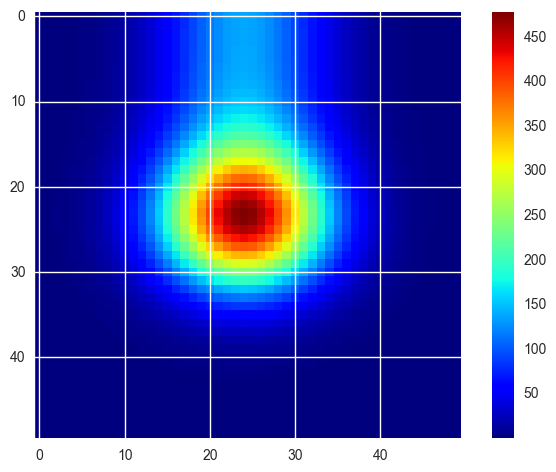

In [2]:
# Define image size, starting vectors
image_size=50
x=np.linspace(1,image_size,image_size)
y=np.linspace(1,image_size,image_size)
x,y=np.meshgrid(x, y)

# 2D Gaussian image model
theta = (image_size/2,image_size/2,400,image_size/7.5,image_size/9,0,0)
image = pm.MOT_bare_model(x,y,theta)

# 2D Gaussian image model + CCD readout charge noise
image = pm.Image_with_CCD_readout_charge(image, 40)

plt.figure(1)
plt.imshow(image,cmap="jet", interpolation='none')
plt.colorbar()

Then we add two other sources of noise: the background scattered light which is detected by the PMTs, which also have some Poissonian noise in them:

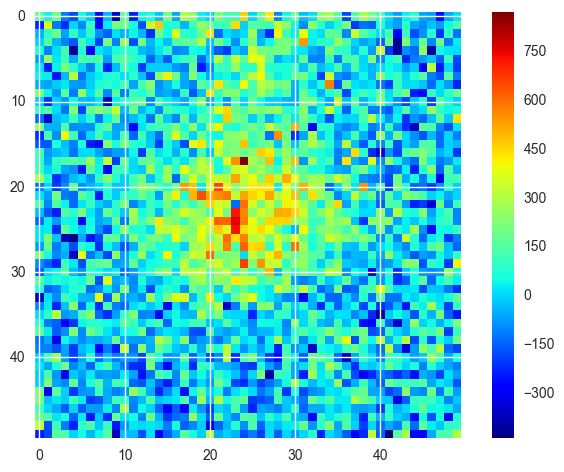

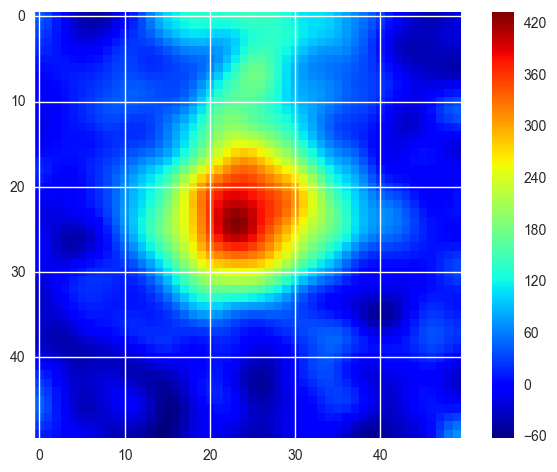

In [3]:
image_poisson = image + pm.detected(pm.background(image_size,0,10000))-pm.detected(pm.background(image_size,0,10000))

plt.figure(1)
plt.imshow(image_poisson,cmap="jet", interpolation='none')
plt.colorbar()

plt.figure(2)
plt.imshow(filters.gaussian_filter(image_poisson,2),cmap="jet", interpolation='none' )
plt.colorbar()

Finally, save the image to a csv file, which we can use later as our model data:

In [4]:
time = 100 # (ms) random choice
np.savetxt("model_data.csv", image_poisson, delimiter=" ")

## Likelihood function

To construct the likelihood function we need to consider all the uncertainties. Thus, each data point is given by: 

$$y_{\mathrm{i}} = z_{\mathrm{i}} + e_{\mathrm{i}} = m(x_{\mathrm{i}}, \theta) + \epsilon_{\mathrm{i}} + f_{\mathrm{i}} + g_{\mathrm{i}} + sct_{\mathrm{i}},$$

where $m(x_{\mathrm{i}}, \theta)$ is the model data and $\theta$ the set of parameters that go into the data.

Following the methods of Gregory 4.8, we have the probability distribution for the proposition $Z_i$ that the model we considered gives for the $i$-th data point values in the range $z_{\mathrm{i}}$ to $z_{\mathrm{i}} + dz_{\mathrm{i}}$:

$$p(Z_{\mathrm{i}}|M, \theta, I) = f_{\mathrm{Z}}(z_{\mathrm{i}}) = \frac{1}{\sqrt{2 \pi}\sigma_{\mathrm{mi}}} exp \left( \frac{- \epsilon_i}{2 \sigma_{\mathrm{mi}}} \right)$$.

Note that for simplicity we will consider $\epsilon_{\mathrm{i}} = \epsilon$ and $\sigma_{\mathrm{mi}} = \sigma_{\mathrm{m}}$, for all $i$.

Next the shot noise component is given by:

$$p(F_{\mathrm{i}}|M, \theta, I)  = e^{-\mu_fi} \frac{\mu_{\mathrm{fi}}^n}{n!}.$$

A similar expression applies to the scattered light noise, with expected photon number $\mu_{\mathrm{scti}}$.

Finally, include the readout noise. For now, only consider it as a simple Gaussian but can easily add a prior of the form sum(z(x0, y-i)), for $i$ from $0$ to $y0$, where (x0, y0) are the coordiantes of the pixel we are analyzing. Then the noise is really this Gaussian likelihood times the prior.

$$p(G_{\mathrm{i}}|M, \theta, I) = \frac{1}{\sqrt{2 \pi}\sigma_{\mathrm{gi}}} exp \left( \frac{- g_i}{2 \sigma_{\mathrm{gi}}} \right)$$

The likelihood for each pixel is then the convolution of the noise sources and the total likelihood is the product of all likelihoods for each pixel (so for log of the likelihood we perform a sum). For the first stages of the project we perform the convolution directly:

NOTE: In this simple version of the model, the two Gaussian uncertainties convolve to a Gaussian with $\sigma = \sigma_{\mathrm{m}} + \sigma_{\mathrm{g}}$

### Load sample data:

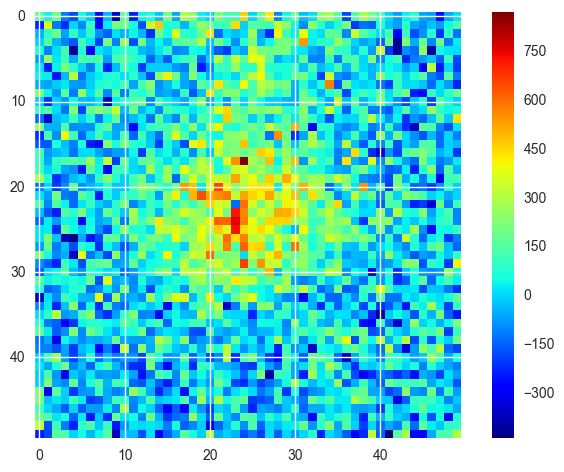

In [5]:
model_data_path = get_data_file_path('model_data.csv')
model_data = load_data(data_file = model_data_path, delim = ' ')

image_size = 50 

image_object = load_image(model_data)

# Try method of the class
image_object.show(gauss_filter = False)

### Running MCMC
We run MCMC using the pm.sampler function, which calls upon the emcee package to comptue marginal posteriors for the model parameters. There are 8 parameters to be marginalized over, which is encompassed in the variable theta in our package. theta is an array consisting of the following parameters:

(center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g)

The first 5 parameters give the 2D Gaussian for the MOT. background_offset is self-explanator. sigma_m is the uncertainty in the model, and sigma_m is the uncertainty from the scattered light background. 

In [6]:
initial_guess = [25, 25, 400, 6.6667, 5.5556, 100, 20] # from HBL figure 1 and randomly guessing
emcce_sample = pm.sampler(model_data, 7, 50, 700,image_size,initial_guess)

Done


We plot the steps of the walkers in sigma_x, sigma y:

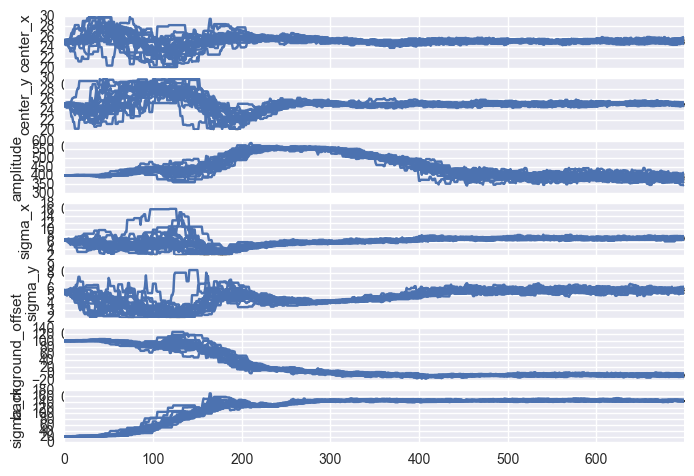

In [7]:
fig, (ax_center_x, ax_center_y, ax_amplitude, ax_sigma_x, ax_sigma_y, ax_background_offset, ax_sigma_m) = plt.subplots(7)

ax_center_x.set(ylabel='center_x')
ax_center_y.set(ylabel='center_y')
ax_amplitude.set(ylabel='amplitude')
ax_sigma_x.set(ylabel='sigma_x')
ax_sigma_y.set(ylabel='sigma_y')
ax_background_offset.set(ylabel='background_offset')
ax_sigma_m.set(ylabel='sigma_m')

for i in range(20):
    sns.tsplot(emcce_sample.chain[i,:,0], ax=ax_center_x)
    sns.tsplot(emcce_sample.chain[i,:,1], ax=ax_center_y)
    sns.tsplot(emcce_sample.chain[i,:,2], ax=ax_amplitude)
    sns.tsplot(emcce_sample.chain[i,:,3], ax=ax_sigma_x)
    sns.tsplot(emcce_sample.chain[i,:,4], ax=ax_sigma_y)
    sns.tsplot(emcce_sample.chain[i,:,5], ax=ax_background_offset)
    sns.tsplot(emcce_sample.chain[i,:,6], ax=ax_sigma_m)

As the MCMC settles after some steps, we throw away the first  500 steps:

In [8]:
ndim = 7

samples = emcce_sample.chain[:,500:,:]
traces = samples.reshape(-1, ndim).T

parameter_samples = pd.DataFrame({'sigma_x': traces[3], 'sigma_y': traces[4]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)
sigma_x = q['sigma_x'][0.50]
sigma_y = q['sigma_y'][0.50]

print(q)

       sigma_x   sigma_y
0.16  6.827191  5.422871
0.50  7.136980  5.665688
0.84  7.482495  5.936697


C:\Users\Loic\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


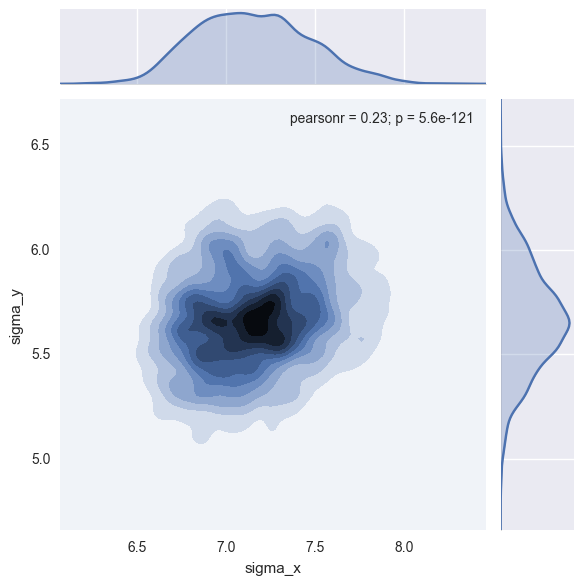

In [9]:
joint_kde = sns.jointplot(x='sigma_x', y='sigma_y', data=parameter_samples, kind='kde')

## Running as a Script

The above process (generation of simulated data and fitting to it) can also be run as a script: model.py. We run it here to show that it does work:

In [11]:
%run './params_MOT/model.py'

ERROR:root:File `"'./params_MOT/model.py'.py"` not found.
